<a href="https://colab.research.google.com/github/Last-Vega/Klis_Workshop_MachineLearning/blob/master/CJSJ_ML_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorchによる画像処理（畳み込みニューラルネットワークの利用）

犬と猫の画像の分類を畳み込みニューラルネットワークを用いて行う．

**なお，畳み込みニューラルネットワークの学習はCPUでは時間がかかりすぎてしまうため，
「ランタイム」メニュー→「ランタイムのタイプを変更」を選んでハードウェアアクセラレータを「GPU」に変更しておこう．**

## 画像データセットの読み込み

再度，犬と猫の画像データを https://drive.google.com/file/d/1ldKEtetkjjuxPxRQ4-_9YHsD-u9VtxbA/view からダウンロードして，Colabへアップロードし使えるようにしておこう．これを行うためには，画面左側にあるフォルダのアイコンをクリックしcat_dog_images.zipをドラッグアンドドロップすればよい．

## 画像データの読み込み

この箇所はほとんど前回の演習で行った内容と同じである．

In [ ]:
# zipファイルを展開する
!unzip cat_dog_images.zip

In [ ]:
import torchvision # PyTorchの中でも特に画像データの扱いに特化したパッケージ
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# 画像に対して実行する前処理を定義するクラス
class ImageTransform():
    def __init__(self):
        self.data_transform = transforms.Compose([
            transforms.Resize((224, 224)), # 画像のサイズを揃える必要があるので224 x 224に統一
            transforms.ToTensor()
        ])
    
    def __call__(self, img):
        return self.data_transform(img)

# torchvision.datasets.ImageFolderは
# あるフォルダ中に含まれるフォルダ名をラベルとして，その中に含まれる画像はそのラベルが付与されていると解釈し，
# 画像データを読み込む
image_dir = "/content/cat_dog_images" # アップロードしたzipファイルがcat_dog_imagesというフォルダに展開されるはず
dataset = torchvision.datasets.ImageFolder(image_dir, transform=ImageTransform())

In [ ]:
from torch.utils.data import DataLoader, random_split

train_size = 167 # 先頭の167件を訓練データとして用いることにする
batch_size = 32 # ミニバッチのサイズを設定，増やしても減らしても良い

# 訓練データとテストデータに分割
train_dataset, test_dataset = random_split(dataset, [train_size, len(dataset)-train_size])

# 訓練データを読み込むためのデータローダーを準備．shuffle=Trueはミニバッチを作る際に，画像の順序をランダムにするオプション．
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

## 物体認識の機械学習モデル（畳み込みニューラルネットワークの利用）

今回は畳み込みニューラルネットワークを用いて物体認識を行う機械学習モデルを構築する．
特に比較的構造がシンプルなVGGというモデルを採用し，このモデルを拡張することによって物体認識を行う．本来のVGGモデルは1,000クラス分類を行うように設計されているため，出力層を変更して2クラス分類を行うように修正する必要がある．

In [ ]:
import torchvision.models as models
import torch.nn as nn

model = models.vgg11() # vgg11モデルのインスタンスを作成
num_ftrs = model.classifier[6].in_features # 最後の層の入力次元数を取得
model.classifier[6] = nn.Linear(num_ftrs, 1) # 2クラス分類用に出力層を修正．これを行う場合と行わない場合で出力を比べると良い．

model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

## 物体認識モデルの学習

訓練データを用いて先ほど定義した`ImageClassifier`モデルを学習してみよう．
学習にはミニバッチ勾配降下法を用いることにする．また，交差エントロピーを最小化するようなパラメータを採用することにする．

このコードは前回のコードと全く同じものである．

In [ ]:
import torch
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # CPUもしくはGPUのどちらを使うかを設定
model = model.to(device) # CPUもしくはGPUのどちらを設定
optimizer = optim.Adam(model.parameters()) # 基本的な学習方法はミニバッチ勾配降下法ではあるが，その中でもよく用いられるAdamと呼ばれる方法を用いることにする

criterion = nn.BCEWithLogitsLoss() # 二値分類用の交差エントロピーを最小化することにする

epoch_size = 10 # 勾配降下法はすべてのデータでパラメータを更新したら終わりではなく，全データでの更新（=1エポック）を複数回行う必要がある

model.train() # モデルを学習モードに変更

# `epoch_size`の数だけ以下を繰り返す
for epoch in range(epoch_size):
    losses = []
    # データローダーはミニバッチ勾配降下法のために，`batch_size`で指定した数ごとにデータをわけて読み込んでくれる．
    for batch_idx, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad() # 勾配の初期化
        y = model(images) # 現時点でのモデルの出力を得る
        y = y.squeeze() # yは`batch_size` x 1の**行列**になっているので，これを`batch_size`次元の**ベクトル**に変換
        loss = criterion(y, labels.type(torch.float)) # 交差エントロピーの計算
        loss.backward() # 交差エントロピーの勾配計算
        optimizer.step() # パラメータ更新
        losses.append(loss.item())

    # 現在の交差エントロピーを出力
    print('Epoch: {}\tCross Entropy: {:.6f}'.format(epoch, sum(losses)))

Epoch: 0	Cross Entropy: 2.797438
Epoch: 1	Cross Entropy: 1.207366
Epoch: 2	Cross Entropy: 0.781740
Epoch: 3	Cross Entropy: 0.562690
Epoch: 4	Cross Entropy: 0.538782
Epoch: 5	Cross Entropy: 0.403508
Epoch: 6	Cross Entropy: 0.322906
Epoch: 7	Cross Entropy: 0.372647
Epoch: 8	Cross Entropy: 0.277685
Epoch: 9	Cross Entropy: 0.192643


## 物体認識モデルの評価

学習されたニューラルネットワークモデルを評価してみよう．
訓練データにおいて機械学習モデルの交差エントロピーを最小化するようなパラメータは，
テストデータにおいて性能指標を最大化していることを期待するのである．

性能指標には精度を用いて予測結果を評価してみよう．

In [ ]:
correct = 0
model.eval() # モデルを評価モードに変更
for batch_idx, (images, labels) in enumerate(test_dataloader):
    images, labels = images.to(device), labels.to(device)
    y = model(images) # モデルの出力を得る
    y = y.squeeze()
    result = torch.sigmoid(y) # `ImageClassifier`ではsigmoid関数を適用していなかったのでここで適用
    prediction = result >= 0.5 # `result`ベクトルと同じ次元を持ち，`result`の中で0.5以上である次元がTrue，それ以外がFalseであるベクトルを`prediction`とする
    target = labels == 1 # `labels`ベクトルと同じ次元を持ち，`labels`の中で1である次元がTrue，それ以外がFalseであるベクトルを`target`とする
    correct_num = target.eq(prediction).sum().item() # `prediction`ベクトルと`target`ベクトルでTrue/Falseが一致したものの数を数える
    correct += correct_num

# test_dataloader.datasetにはテストデータ全体が入っているので，これの長さはテストデータの事例数となる
print("Accuracy: {:.3f}".format(correct / len(test_dataloader.dataset)))

NameError: ignored

## 事前学習モデルの利用

モデルは適切であるはずであるが精度は高くなかったであろう．これは主に訓練データが少ないことが原因である．深層学習を行って大量のパラメータを学習する場合には，大量の訓練データが必要となる．しかしながら，類似のタスクによって既に学習されているモデルを活用できるのであれば，一部のパラメータを再学習すればよく，そこまで多くの学習データは必要にはならない．これを実践してみよう．

事前学習モデルとしては，Imagenetデータセットで学習された1,000クラス分類用のモデルを利用する．このモデルのすべての層のパラメータは，今回の学習では変更しないようにして，既に学習されたパラメータを利用することにする．一番最後の全結合層を2クラス分類用に変更して，この層のパラメータだけを学習するように設定を行う．

以下のセルを実行後に，学習，および，評価のセルを実行してみよう．劇的に精度が改善されているはずである．

In [ ]:
import torchvision.models as models
import torch.nn as nn

model = models.vgg11(pretrained=True) # 事前学習モデルを利用
for param in model.parameters(): # モデル中のパラメータ
    param.requires_grad = False # 事前学習モデルのパラメータ更新を停止
num_ftrs = model.classifier[6].in_features # 最後の層の入力次元数を取得
model.classifier[6] = nn.Linear(num_ftrs, 1) # 2クラス分類用に出力層を修正．この層だけは学習される．

model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

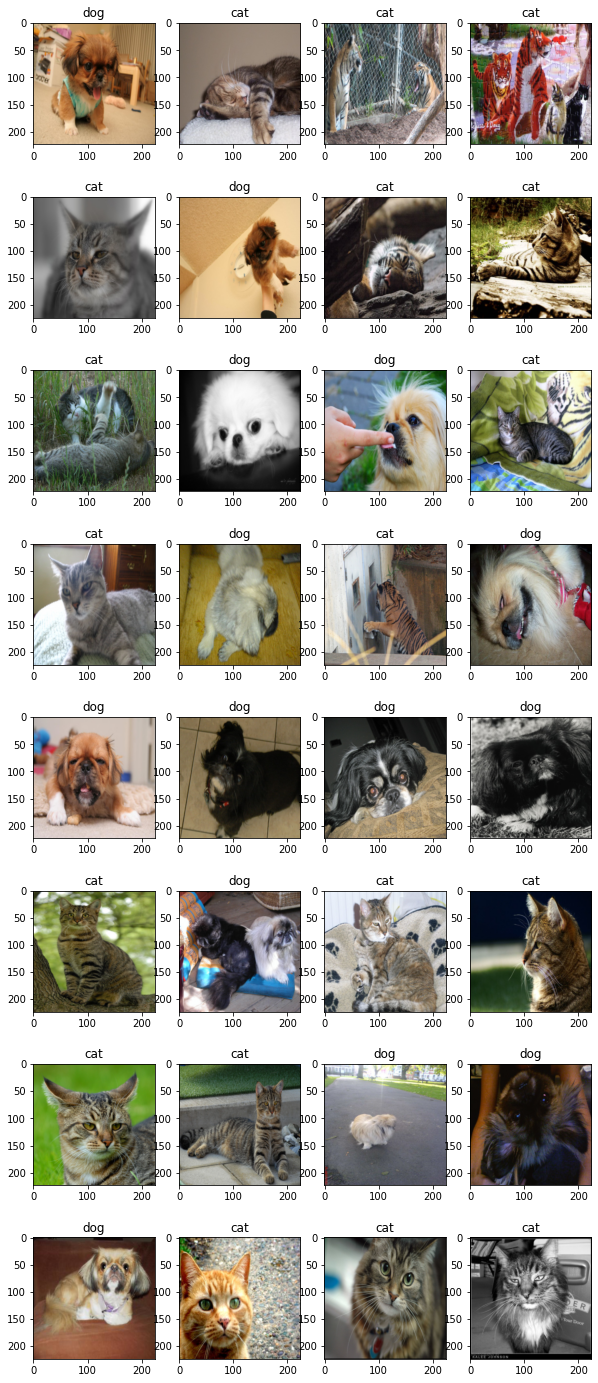

In [ ]:
# VGGの事前学習モデルを再学習し，その予測結果を表示してみよう

%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 25)) # 10 x 25の画像表示域を確保

for images, labels in train_dataloader:
    images, labels = images.to(device), labels.to(device)
    y = model(images) # モデルの出力を得る
    result = torch.sigmoid(y) # `ImageClassifier`ではsigmoid関数を適用していなかったのでここで適用
    # 得られたミニバッチ中の各画像を表示してみる
    for i in range(batch_size):
      if isinstance(images[i], torch.Tensor):
        im = images[i].cpu().permute(1, 2, 0) # 表示用の変換
      else:
        im = images[i].permute(1, 2, 0) # 表示用の変換
      ax = fig.add_subplot(8, 4, i+1) # 8行4列のうち，i+1番目のマスを選択
      label_name = "dog" if result[i] >= 0.5 else "cat" # 結果が0.5以上なら犬，そうでなければ猫
      ax.set_title(label_name) # マスにタイトルを設定
      ax.imshow(im) # 画像を表示
    break # ミニバッチは複数あるが，1個読み込んだら終わるようにbreakをここに入れている

## 今回の物体認識モデルのまとめ

このページで体験してもらいたい重要な点は以下の二点である：

- ディープニューラルネットワークモデルを学習するためには大量の訓練データを必要し，データが少ない場合には良い精度を達成することはできない
- 取り組みたい問題と類似する問題を解くための学習済みモデルがあるのならば，そのモデルを再学習することによって，少量のデータであっても深層学習モデルを学習することが可能である．